# This notebook 
## 1. Calculates the alignment between coastal normal vectors and ERA 5 wind velocity vectors
## 2. Explores the correlation between normal/velocity vector alignment and probability of beaching

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
# dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tqdm import tqdm

import scipy.interpolate as sci_int
import scipy.stats as sci_stats
import geopandas as gpd

In [3]:
# load u and v CSVs:
u_df = pd.read_csv('u_df.csv')
v_df = pd.read_csv('v_df.csv')

# load wind CSV:
avg_u_winds = pd.read_csv('avg_u_winds.csv')
avg_v_winds = pd.read_csv('avg_v_winds.csv')

# load probability of beaching data
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

### First we need to reduce the dimensions of the wind data by averaging:

In [4]:
def df_aggregation_by_factor_8(df):
    # keep original df unaffected
    working_df = df.copy()

    # initialize row mean:
    row_means = []
    
    # for each odd row    
    for i in tqdm(range(0, len(working_df), 2)):

        # initialize column mean:
        col_means = []
        
        # for each odd col
        for j in range(0, len(working_df.columns), 2):  

            # get 3x3 matrix around current grid cell
            matrix = working_df.iloc[i-1:i+2, j-1:j+2].values
            
            # get mean of matrix
            matrix_mean = matrix.mean()
            
            col_means.append(matrix_mean)
            
        row_means.append(col_means)
        
    result_df = pd.DataFrame(row_means)
    
    return result_df

In [5]:
# define desired rows and desired cols
desired_rows = 360
desired_cols = 180

# perform aggregation on wind dfs:
#u_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_u_winds.iloc[:-1,:])))
#v_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_v_winds.iloc[:-1,:])))
u_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_u_winds.iloc[:-1,:]))
v_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_v_winds.iloc[:-1,:]))


# define lat and lon:
lats = np.linspace(-90,90,desired_cols)#[10:-10]
lons = np.linspace(-180, 180, desired_rows)

# flip vertically
u_winds = u_winds.iloc[::-1]
v_winds = v_winds.iloc[::-1]

# shift 180 degrees lon
u_winds =  pd.concat([u_winds.iloc[:, u_winds.shape[1] // 2:], u_winds.iloc[:, :u_winds.shape[1] // 2]], axis=1)
v_winds =  pd.concat([v_winds.iloc[:, v_winds.shape[1] // 2:], v_winds.iloc[:, :v_winds.shape[1] // 2]], axis=1)

  0%|          | 0/360 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 180/180 [00:06<00:00, 27.06it/s]


In [6]:
lats = np.linspace(-90,90,desired_cols)#[10:-10]
lons = np.linspace(-180, 180, desired_rows)

In [7]:
# remove beyond -70 and 70 degrees lat:
#u_winds1 = u_winds[10:-10]
#v_winds1 = v_winds[10:-10]
u_winds1 = u_winds#[10:-10]
v_winds1 = v_winds#[10:-10]

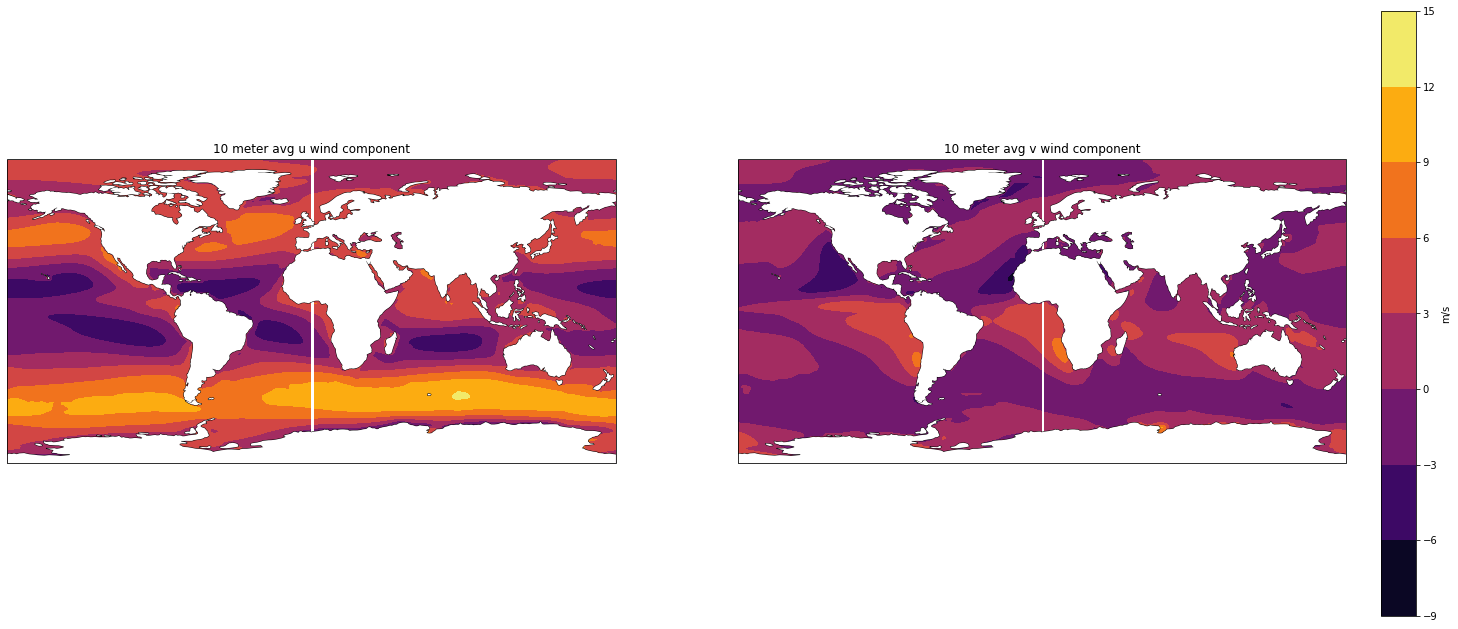

In [8]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, u_winds1, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('10 meter avg u wind component')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons, lats, v_winds1, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('10 meter avg v wind component')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

### Now we calculate the alignment of the coastal normal vectors and wind vectors:

In [9]:
np.shape(u_winds1)

(180, 360)

In [10]:
# get u and v components of coastal norms and wind velocity
u_df_array = u_df.values
v_df_array = v_df.values
u_winds_array = u_winds1.values
v_winds_array = v_winds1.values

In [11]:
positions = []

u_list = []
v_list = []

u_winds_list = []
v_winds_list = []

# Iterate over the dataframes to extract non-NaN values and their positions
for i in range(u_df.shape[0]):
    for j in range(u_df.shape[1]):
        if not np.isnan(u_df.iat[i, j]) and not np.isnan(v_df.iat[i, j]):
            u = u_df.iat[i, j]
            v = v_df.iat[i, j]
            u_wind = u_winds1.iat[i, j]
            v_wind = v_winds1.iat[i, j]
            
            # Store the position and the vector components
            positions.append((i, j))
            u_list.append(u)
            v_list.append(v)
            
            u_winds_list.append(u_wind)
            v_winds_list.append(v_wind)

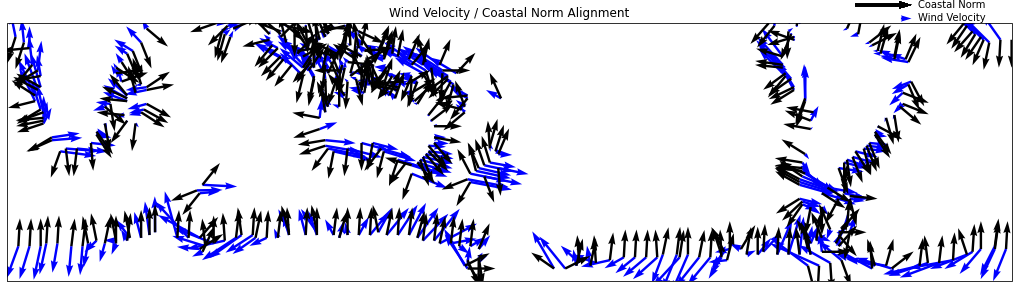

In [14]:
# Create a mask to filter out NaN values in coastal norms
mask = ~np.isnan(u_df.values)

# Get the indices where mask is True
indices = np.where(mask)

# visualize alignment
fig, ax = plt.subplots(1, 1, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


# convert positions to X and Y arrays
positions = np.array(positions)
X, Y = positions[:, 1], positions[:, 0]

# Plot wind vectors where coastal norms are non-NaN
wind_q = ax.quiver(X[::4], Y[::4], u_winds_list[::4], v_winds_list[::4], color='blue', scale=190)

# Plot coastal norm vectors where coastal norms are non-NaN

coast_norm_q = ax.quiver(X[::4], Y[::4], u_list[::4], v_list[::4], angles = 'xy', scale_units = 'xy', scale = 0.1)

ax.set_title('Wind Velocity / Coastal Norm Alignment')


# Add a legend
ax.quiverkey(wind_q, 0.9, 1.02, 2, 'Wind Velocity', color='blue', labelpos='E')
ax.quiverkey(coast_norm_q, 0.9, 1.07, 2, 'Coastal Norm', color='k', labelpos='E')

# Show the plot
plt.show()

In [43]:
# compute dot product of coastal normal vectors and wind velocity vectors
dot_product = np.array(u_winds_list) * np.array(u_list) + np.array(v_winds_list) * np.array(v_list)
dot_product = dot_product / np.sqrt(np.array(u_winds_list)**2 + np.array(v_winds_list)**2)
# Create an empty DataFrame with the desired shape (70, 180)
rows, cols = 160, 360
alignment = pd.DataFrame(np.nan, index=np.arange(rows), columns=np.arange(cols))

# Convert dot_product to 1D array if it's not already
dot_product = dot_product.flatten()

# Fill the DataFrame with the dot product values at the corresponding positions
for (i, j), value in zip(positions, dot_product):
    alignment.iat[i, j] = value



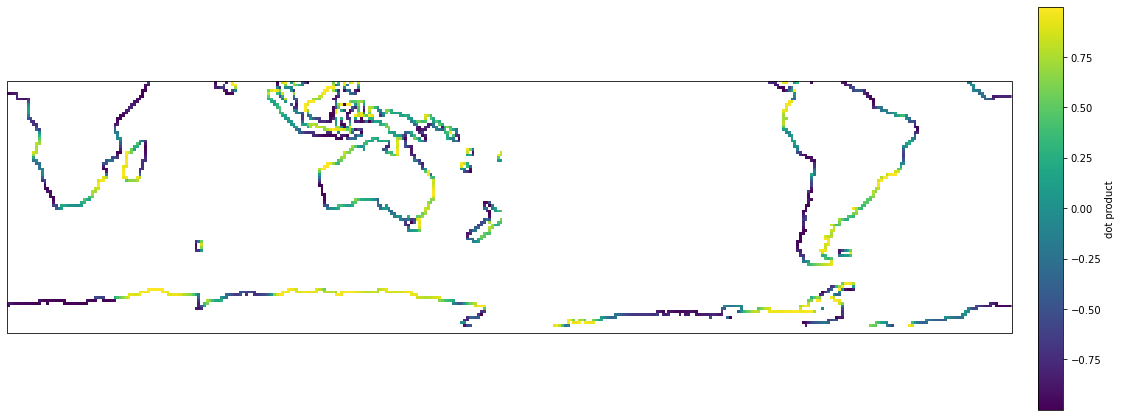

In [44]:
# visualize alignment
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


im1 = ax1.pcolormesh(alignment,cmap='viridis', transform=ccrs.PlateCarree())



# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='dot product')

# Show the plot
plt.show()

### Let's compare these alignments to the probability of beaching in those grid cells

In [45]:
# we follow the steps in the probability of beaching notebook:
# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])


In [46]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

In [47]:
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

In [48]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued)#.iloc[10:-10]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


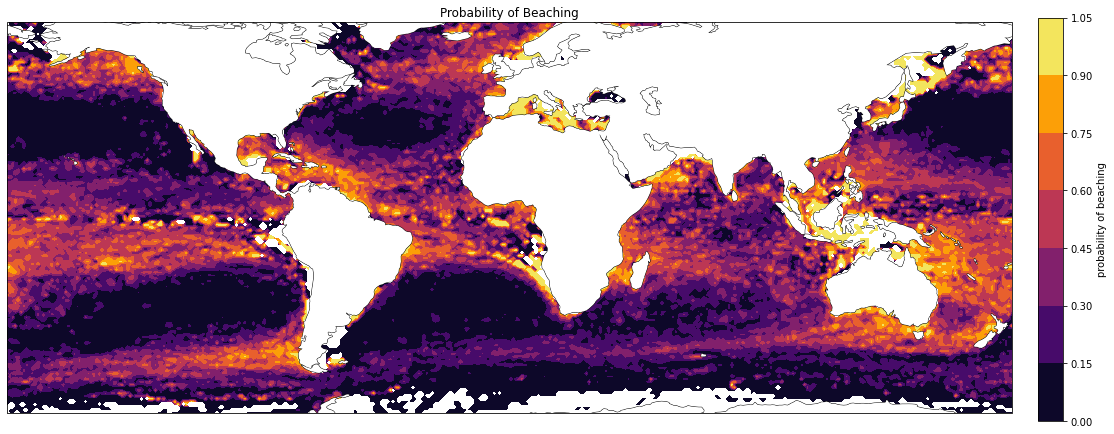

In [49]:
# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, beach_prob_vals, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='probability of beaching')

# Show the plot
plt.show()

#### So at every location that is coastal (has a non_NAN 'alignment' value), we want to see what the probability of beaching is

In [50]:
# initialize output lists
beach_prob_list = []
alignment_list = []

# through rows
for i in range(alignment.shape[0]):
    
    # through cols
    for j in range(alignment.shape[1]):
        
        # if not NAN
        if not np.isnan(alignment.iloc[i, j]):
            
            # append value from beach_prob and alignment to their list
            beach_prob_list.append(beach_prob.iloc[i, j])
            alignment_list.append(alignment.iloc[i, j])

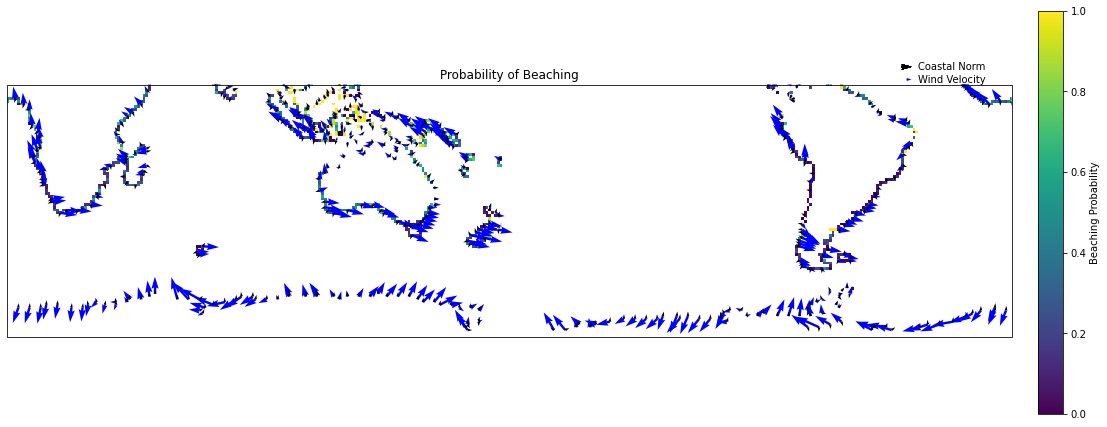

In [60]:
# Create an empty DataFrame with the same shape as alignment
beach_prob_df = pd.DataFrame(np.nan, index=alignment.index, columns=alignment.columns)

# Fill the DataFrame with the beach_prob_list values at the corresponding positions
for (i, j), value in zip(positions, beach_prob_list):
    beach_prob_df.iat[i, j] = value

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


# Create the meshgrid for plotting
lon, lat = np.meshgrid(beach_prob_df.columns, beach_prob_df.index)

# Plot the data using pcolormesh
im1 = ax1.pcolormesh(lon, lat, beach_prob_df, cmap='viridis', transform=ccrs.PlateCarree())

ax1.set_title('Probability of Beaching')

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='Beaching Probability')


# convert positions to X and Y arrays
positions = np.array(positions)
X, Y = positions[:, 1], positions[:, 0]

# Plot wind vectors where coastal norms are non-NaN
wind_q = ax1.quiver(X[::4], Y[::4], u_winds_list[::4], v_winds_list[::4], color='blue', scale=400)

# Plot coastal norm vectors where coastal norms are non-NaN

coast_norm_q = ax1.quiver(X[::4], Y[::4], u_list[::4], v_list[::4], angles = 'xy', scale_units = 'xy', scale = 0.6)

ax.set_title('Wind Velocity / Coastal Norm Alignment')


# Add a legend
ax1.quiverkey(wind_q, 0.9, 1.02, 2, 'Wind Velocity', color='blue', labelpos='E')
ax1.quiverkey(coast_norm_q, 0.9, 1.07, 2, 'Coastal Norm', color='k', labelpos='E')

# Show the plot
plt.show()

In [52]:
# id nan indices
nan_indices = np.isnan(np.array(alignment_list)) | np.isnan(np.array(beach_prob_list))

# remove nans
alignment_list_f = np.array(alignment_list)[~nan_indices]
beach_prob_list_f = np.array(beach_prob_list)[~nan_indices]

# fit a line:
coefficients  = np.polyfit(alignment_list_f, beach_prob_list_f, 1)
predicted_values = np.polyval(coefficients, alignment_list_f)
#coefficients  = np.polyfit(beach_prob_list_f,alignment_list_f, 1)
#predicted_values = np.polyval(coefficients, beach_prob_list_f)

# calculate r2
p = np.poly1d(coefficients)
r_squared = np.corrcoef(beach_prob_list_f, p(alignment_list_f))[0, 1] ** 2

In [53]:
r_squared

5.261821791693138e-06

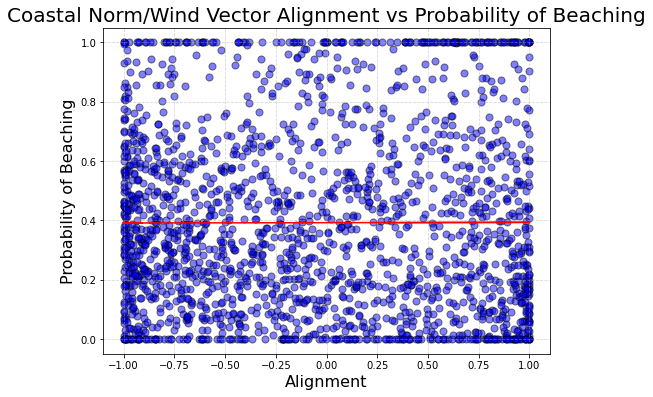

In [54]:
# visualize correlation between the two
plt.figure(figsize=(8, 6))
plt.scatter(alignment_list, beach_prob_list, s=50, c='blue', alpha=0.5, edgecolors='k')
plt.plot(alignment_list_f, predicted_values, color='r', linestyle='-', label='Fitted Line')

plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel('Alignment', fontsize=16)
plt.ylabel('Probability of Beaching', fontsize=16)

plt.tick_params(axis='both', which='both', labelsize=10)

plt.title('Coastal Norm/Wind Vector Alignment vs Probability of Beaching', fontsize=20)

plt.show()

### apply uniform rotation to winds to check ekman 
### map of ocean currents and winds, correlation to stuff

# to try: guassian filter. larger probability beaching grid cells: get coherent blobs of probability

In [62]:
lats = np.linspace(-90,90,desired_cols)#[10:-10]
lons = np.linspace(-180, 180, desired_rows)
u_winds_array
v_winds_array

array([[3.89953018, 3.91298358, 3.92196645, ..., 3.86064799, 3.87560112,
        3.88636567],
       [5.57075071, 5.62377181, 5.68459538, ..., 5.549443  , 5.5532966 ,
        5.55755738],
       [6.5817008 , 6.6611974 , 6.73187365, ..., 6.40803694, 6.45029951,
        6.51220997],
       ...,
       [0.8445827 , 0.83165188, 0.81909036, ..., 0.88479734, 0.87162253,
        0.85830854],
       [0.84002603, 0.82841571, 0.81704511, ..., 0.87314902, 0.86221632,
        0.85146488],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [72]:
np.shape(lats)

(180,)

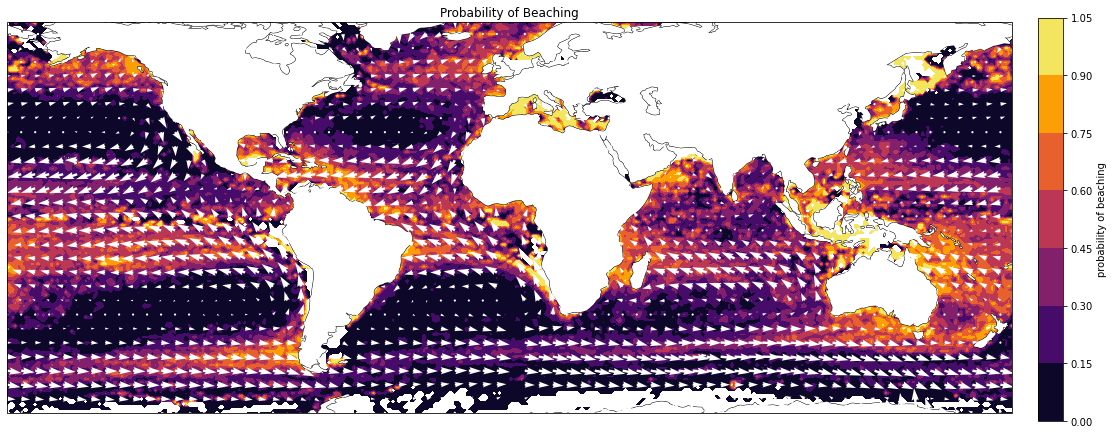

In [77]:
# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, beach_prob_vals, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='probability of beaching')




# Plot wind vectors
wind_q_global = ax1.quiver(lons[::5], lats[::5], u_winds_array[::5,::5], v_winds_array[::5,::5], color='white', scale=500)




# Show the plot
plt.show()

## make figure above but for ocean currents (aviso\duacs geostrophic currents)

## coastal grid: numerator is number of drifters that beached in that grid box, denominator is all drifters that were ever in that box